In [1]:
#coding:utf-8
# 载入必要的packages
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.externals import joblib
from matplotlib import pyplot as plt
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from sklearn import svm
from tqdm import tqdm_notebook
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
%matplotlib inline

C:\Software\Programming\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


在安装完lifelines之后lift.asv和lift_TF.asv的读取出现了问题，应该是pickle不兼容，需要的话lift和lift_TF的话要去Data Processing页面重新生成

In [2]:
#lift=joblib.load('lift.asv') #其实只要用这个就够了的
#lift_TF=joblib.load('lift_TF.asv')
lift_series_dict=joblib.load('lift_series_dict.asv')
lift_time_series_dict=joblib.load('lift_time_series_dict.asv')
lift_recur_train_table=joblib.load('lift_recur_train_table.asv')
x_train=joblib.load('x_train_notsfresh_intervalPredict_0220.asv')
x_test=joblib.load('x_test_notsfresh_intervalPredict_0220.asv')
y_train=joblib.load('y_train_notsfresh_intervalPredict_0220.asv')
y_test=joblib.load('y_test_notsfresh_intervalPredict_0220.asv')
components_dict=joblib.load('components_dict.asv')
components_dict_re=joblib.load('component_dict_re.asv')
lift_recur_train_table_correct=joblib.load('lift_recur_train_table_correct.asv')
lift_comp_series_dict=joblib.load('lift_comp_series_dict.asv')
lift_comp_recur_train_table=joblib.load('lift_comp_recur_train_table.asv')
# 模型评估
def predict_and_score(model, X, Y):
    pred=model.predict(X)
    score=np.sqrt(mean_squared_error(Y,pred))
    R=model.score(X,Y)
    return (score,pred,R)

def printModelInformation(pred,test):
    print('MAE: ',mean_absolute_error(pred,test))
    print('MSE: ',mean_squared_error(pred,test))
    print('R2: ',r2_score(pred,test))

(array([1.0000e+00, 1.1569e+05, 1.7733e+04, 1.6762e+04, 1.6019e+04,
        1.4508e+04, 1.2936e+04, 1.1544e+04, 1.0271e+04, 9.3690e+03,
        8.6190e+03, 6.7350e+03, 5.4310e+03, 4.4170e+03, 3.1640e+03,
        2.2640e+03, 1.4730e+03, 8.3400e+02, 4.2800e+02, 6.0000e+01]),
 array([-22. ,  -2.9,  16.2,  35.3,  54.4,  73.5,  92.6, 111.7, 130.8,
        149.9, 169. , 188.1, 207.2, 226.3, 245.4, 264.5, 283.6, 302.7,
        321.8, 340.9, 360. ]),
 <a list of 20 Patch objects>)

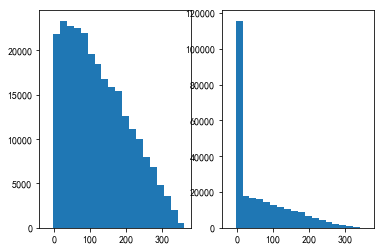

In [110]:
f,(ax1,ax2)=plt.subplots(1,2)
ax1.hist(lift_recur_train_table['nextRepairInt'],bins=20)
ax2.hist(lift_recur_train_table['lastRepairInt'],bins=20)

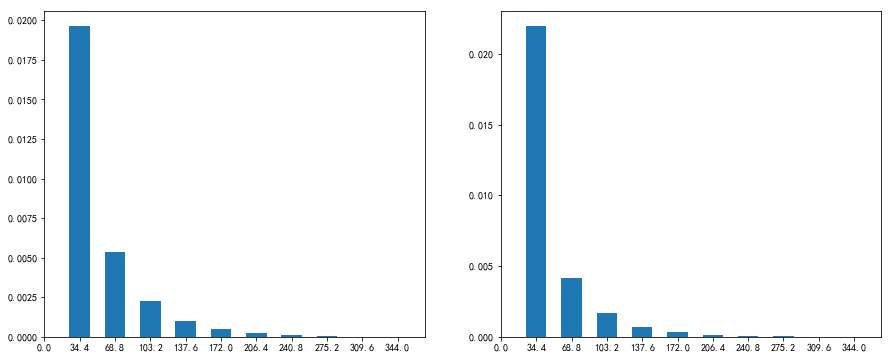

In [125]:
n=lift_recur_train_table_correct['nextRepairInt']
l=lift_recur_train_table_correct['lastRepairInt']
n[np.where(n<0)[0]]=0
l[np.where(l<0)[0]]=0
f,(ax3,ax4)=plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(15)
a=np.histogram(n,normed=True)
ax3.bar(a[1][1:],a[0],width=20)
ax3.set_xticks(a[1])
a=np.histogram(l,normed=True)
ax4.bar(a[1][1:],a[0],width=20)
ax4.set_xticks(a[1])

可以看出“下一次故障时间间隔”符合威布尔分布，而“上一次时间间隔”则是威布尔分布向左平移的结果

# 假设
1. PM间隔和系统的年龄年龄和历史维修次数有关(即此前做的基于历史维修次数的故障间隔预测)
2. 针对电梯整体的失效模式进行考量，不考虑部件
3. 走修能够将状态回复到 $\tau$ 时刻之前，而 $\tau$ 应当小于等于时间间隔$\Delta t$，较优的是恢复到故障前的最小维修，最理想的是回复如新的完全维修，为了简化模型先考虑最小维修
4. PM间隔$\Delta t$里至多只有一次故障，因为实际情况便是，故障发生后维修，再开启新一轮的PM
5. 决策是在每一次故障后进行

定义变量
\begin{itemize}
\item $\Delta t$为PM的维修时间间隔，为自变量
\item T为该时间距离下一次失效的时间间隔(time to failure)，由此前的故障预测模型得出
\item $C_{p}$为每一次PM的成本
\item $C_{f}$为故障出现的成本
\item $h(t)$ 为失效函数，符合威布尔分布[cite{canfield1986cost}], H(t)则为其累计分布函数
\item $[x]$为不超过x的最大整数
\item $\vec{ \beta}$ 为该电梯的各项特征的向量
\end{itemize}


因而对于维保的情景下，时间成本率函数$C(\Delta t)$的表达式可以表述为 <mark>一台电梯可以，但是要summation（求解复杂度随样本容量线性增加）,一整个系统也可以，需要mean time to failure</mark>

\begin{equation}\label{eq:1}
    C(\Delta t)=\frac{C_{p}([\frac{T}{\Delta t}])+ C_{f}H(\Delta t, t,\vec{\beta})}{T}
\end{equation}

约束：

\begin{itemize}
\item 不管是一个电梯还是一个系统，$C(\Delta t)< [\frac{T}{15}]C_{p}$
\end{itemize}
>@article{canfield1986cost,
  title={Cost optimization of periodic preventive maintenance},
  author={Canfield, RV},
  journal={IEEE Transactions on Reliability},
  volume={35},
  number={1},
  pages={78--81},
  year={1986},
  publisher={IEEE}
}

在和通力公司员工和王启刚学长聊天后删去了系统折旧成本$C_{s}$，因为没有准确的更换年限(虽然通常是10-15年)，而且不同的设备折旧是不能够这样简单平摊考量的，更多的还是根据合同订而且数学上来看常数项的意义不是很大。

目前最大的问题还是，如何把预测的T所存在的不确定性考虑进去,而且正常的优化不应考虑动态的量...所以我们就改成实时计算的，最后的决策产品上每一天的实时计算的成本，不过对于本项目而言，电梯公司并不是按照每一次维保进行成本计算,提出成本优化的思路本身及其引入的假设其实有点不切实际。

$C_{f}$均为需要向员工请教的数，最好是经验性质的常量,$C_{p}$由彭世喆建议是300RMB/次，在访问完通力公司后，$C_{p}$基本就是工时费300RMB-400RMB/次


以下先对失效函数h(t)进行拟合，可以近似为威布尔分布(甚至可以得知其形状变量为0.5左右)，其x轴应该是下一次故障间隔(time to failure)，y轴应该是故障所对应的统计概率

# 尝试拟合威布尔

In [23]:
from collections import Counter
weib=stats.exponweib
data=pd.to_numeric(lift_recur_train_table_correct['nextRepairInt'])
data_freq=Counter(data)
data_freq=dict(data_freq)
x_range=np.array(list(data_freq.keys()))
x_range.sort()
x_range=x_range[x_range>=0]
y_range=np.array([data_freq[e] for e in x_range])
#train_weib,test_weib=train_test_split(y_range,train_size=0.8)
# 标准化
#train_weib=train_weib/train_weib.sum()
#test_weib=test_weib/test_weib.sum()
y_range_norm=y_range/y_range.sum()

In [17]:
#weib_params=weib.fit(y_range_norm,floc=0)
#weib_min_params=stats.weibull_min.fit(data)
weib_params=weib.fit(data)
weib_min_params=stats.weibull_min.fit(data)
print(weib_params,'\n',weib_min_params)

(0.9614557951157423, 0.8288205505287549, -2.3887396736043375e-14, 28.225311599554317) 
 (0.24786724484274208, -3.9082189785008454e-26, 2.027631301062203)


In [226]:
print(weib_params,'\n',weib_min_params)

(0.7368763658751805, 0.9531952576380552, -5.562912332258297e-29, 42.406625063417756) 
 (0.8105129948921613, -2.235219326913414e-27, 30.733342988085916)


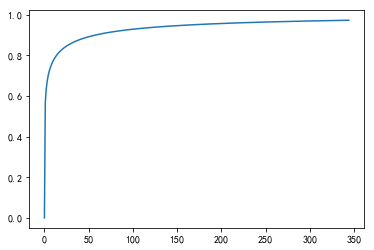

In [25]:
plt.plot(x_range,stats.weibull_min.cdf(x_range,weib_min_params[0],weib_min_params[1],weib_min_params[2]))

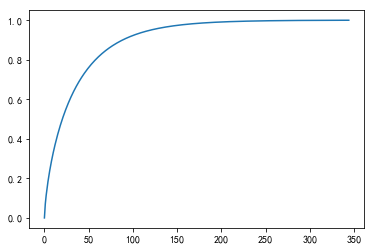

In [232]:
plt.plot(x_range,weib.cdf(x_range,weib_params[0],weib_params[1],weib_params[2],weib_params[3]))

[0.42876158]


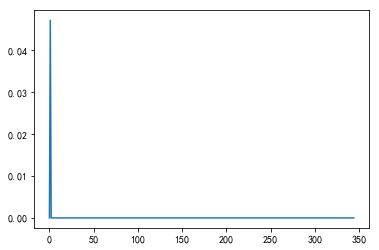

In [46]:
#def Weibull(x,n,a):
#    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a) #n（lambda）＞0是比例参数（scale parameter），a（k）＞0是形状参数（shape parameter）
# 如果形状参数为2
def Weibull(x,n):
    return (2 / n) * (x / n)**(2 - 1) * np.exp(-(x / n)**2) #n（lambda）＞0是比例参数（scale parameter），a（k）＞0是形状参数（shape parameter）

prop,pcov=curve_fit(Weibull,x_range,y_range_norm)
print(prop)
plt.plot(x_range,Weibull(x_range,prop))

[21.69834529]
MAE:  0.002380228774413174
MSE:  3.4949170277247326e-05
R2:  0.34019574103343875


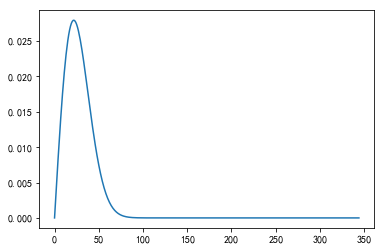

In [53]:
def Rayleigh(x,sigma):
    return x/(sigma**2)*np.exp((-x**2)/(2*(sigma**2)))
#def Rayleigh(x,sigma,a):
#    return a*x/(sigma**2)*np.exp((-x**2)/(2*(sigma**2)))
prop_Rayleigh,pcov_Rayleigh=curve_fit(Rayleigh,x_range,y_range_norm)
print(prop_Rayleigh)
printModelInformation(Rayleigh(x_range,prop_Rayleigh),y_range_norm)

plt.plot(x_range,Rayleigh(x_range,prop_Rayleigh))
#plt.plot(x_range,Rayleigh(x_range,prop_Rayleigh[0],prop_Rayleigh[1]))

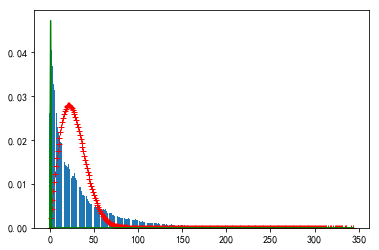

In [45]:
plt.bar(x_range,y_range_norm)
plt.plot(x_range,Rayleigh(x_range,prop_Rayleigh),'r+')
plt.plot(x_range,Weibull(x_range,prop),'g-')
#plt.plot(x_range,Rayleigh(x_range,prop_Rayleigh[0],prop_Rayleigh[1]),'r+')
#plt.plot(x_range,stats.weibull_min.cdf(x_range,weib_params[0],weib_params[1]))
#plt.plot(x_range,weib.pdf(x_range,weib_params[0],weib_params[1]))
#plt.plot(x_range,Weibull(x_range,prop[0],prop[1]),'r--')

$\lambda(x) = \exp\left(\beta_0 + \beta_1x_1 + ... + \beta_n x_n \right)$

In [54]:
help(wf.plot)

Help on method plot in module lifelines.fitters:

plot(**kwargs) method of lifelines.fitters.weibull_fitter.WeibullFitter instance
    Plots a pretty figure of WeibullFitter.cumulative_hazard_
    
    Matplotlib plot arguments can be passed in inside the kwargs, plus
    
    Parameters
    -----------
    show_censors: bool
        place markers at censorship events. Default: False
    censor_styles: bool
        If show_censors, this dictionary will be passed into the plot call.
    ci_alpha: bool
        the transparency level of the confidence interval. Default: 0.3
    ci_force_lines: bool
        force the confidence intervals to be line plots (versus default shaded areas). Default: False
    ci_show: bool
        show confidence intervals. Default: True
    ci_legend: bool
        if ci_force_lines is True, this is a boolean flag to add the lines' labels to the legend. Default: False
    at_risk_counts: bool
        show group sizes at time points. See function ``add_at_risk_co

<lifelines.WeibullFitter: fitted with 163 observations, 7 censored>
number of subjects = 163
  number of events = 156
    log-likelihood = -672.062
        hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_ 55.73      1.33       53.13       58.33 <0.005       inf
rho_     3.45      0.24        2.97        3.93 <0.005     76.83


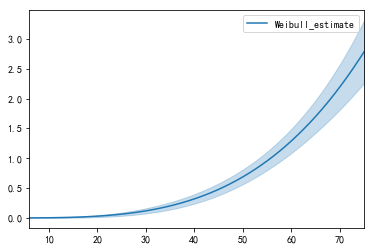

In [56]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

data = load_waltons()

T = data['T']
E = data['E']

wf = WeibullFitter().fit(T, E)

wf.print_summary()
wf.plot()

# 最优PM维修间隔分析
根据cite{zhang2014mixture,jardine1987application}等人的研究，失效函数h(t)可以由威布尔和cox模型进行结合，直接相乘，得到考虑多检测变量下的失效函数，即
\begin{equation}\label{eq:}
    h(t)=h_{0}(t)e^{\beta z_{t}}
   其中 h_{0}(t)= \frac{k}{n}(\frac{t}{n})^{k-1} k为形状参数，n为比例参数
\end{equation}

故
$H(t)=H_{0}(t)*e^{\beta x_{1}+\beta _{2}} H_{0}为威布尔基准的失效累计分布函数$

<mark><b> $h_{0}(t)$以及后面的比例风险系数作为威布尔比例风险模型一并预测，是圣斯后面的工作</b></mark>

~~此前根据圣斯拟合的生存函数$S_{0}(t) = e^{-(\frac{t}{78.22984})^{0.58257}}$可以得知比例系数 $\lambda=78.22984$,形状系数$k=0.58257$~~

根据 https://www.itl.nist.gov/div898/handbook/eda/section3/eda3668.htm 所提供的信息，
威布尔的失效函数累计分布函数为$H(t)=t^{k}=t^{0.58257}$
因此


\begin{equation}\label{eq:2}
     C(\Delta t)=\frac{C_{p}([\frac{T}{\Delta t}])+ C_{f}\Delta t^{0.58257}}{T}
\end{equation}


> @article{zhang2014mixture,
  title={A mixture Weibull proportional hazard model for mechanical system failure prediction utilising lifetime and monitoring data},
  author={Zhang, Qing and Hua, Cheng and Xu, Guanghua},
  journal={Mechanical Systems and Signal Processing},
  volume={43},
  number={1-2},
  pages={103--112},
  year={2014},
  publisher={Elsevier}
}

>@article{jardine1987application,
  title={Application of the Weibull proportional hazards model to aircraft and marine engine failure data},
  author={Jardine, AKS and Anderson, PM and Mann, DS},
  journal={Quality and reliability engineering international},
  volume={3},
  number={2},
  pages={77--82},
  year={1987},
  publisher={Wiley Online Library}
}

Text(0.5,1,'生存函数')

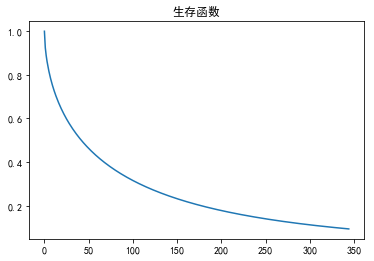

In [243]:
plt.plot(x_range,np.exp(-(x_range/78.22984)**0.58257))
plt.title('生存函数')

针对每一个预测出的故障时间间隔T，成本的最优PM维修间隔$\Delta t$应当也是动态变化的，如果$C_{s},C_{p},C_{f}$都是常数，那么$C(\Delta t)对\Delta t$求导数可得

\begin{equation}
    C'(\Delta t)=-\frac{C_{p}}{(\Delta t)^{2}}+0.58257\frac{C_{f}}{T}(\Delta t)^{-0.41743}
\end{equation}
    
求极小值得

$$
    (\Delta t)^{1.58257}=\frac{C_{p}*T}{0.58257C_{f}}
$$
可以得到成本的函数，但是否也可以对$C_{p}$由于PM维保的灵活性也灵活地变化？或许可以看看相关文献

还不能求导！之前没考虑$[\frac{T}{\Delta t}]$

# 维保可视化产品思路

维保可视化产品功能构思：
* 范围锁定在一个特定地点的电梯（比如虹桥枢纽），做成日历的形式，每一天点开可以得到电梯基本的信息并且能够获取前述的预测信息和成本信息，当需要最优维保的时候，可以预警！

In [3]:
# Model 类
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import calendar
import datetime
from scipy.optimize import fsolve
import sympy as sp

class Model:
    def __init__(self,year=2014,month=5,day=6):
        # Import date and models
        #print('loading data and models')
        self.svr_model=joblib.load('svr_all.joblib')
        self.samples=pd.read_csv('test_sample3.csv')
        self.c=calendar.Calendar()
        # Only use data in Shanghai and Kunshan
        # | (self.samples['City']=='北京') | (self.samples['City']=='深圳')
        self.place=((self.samples['City']=='上海') | (self.samples['City']=='昆山'))
        self.samples=self.samples[self.place]
        self.samples=self.samples.reset_index()
        # Filter data according to the dates
        self.year=year
        self.month=month
        self.day=day
        self.now=datetime.datetime(self.year,self.month,self.day)
        print('->model.now:',self.now)
        self.lr=self.samples['last_repair']
        self.lr_=[]
        for x in self.lr:
            self.lr_.append(self.now) if x is np.nan else self.lr_.append(datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))

        self.t=[self.now-e for e in self.lr_]
        self.t=np.array([e.days for e in self.t])# Time between last repair time and now

        ## Get predicted failure dates
        self.dates_=[datetime.datetime.strptime(x,'%Y-%m-%d') for x in self.samples['date']]
        self.dates_=np.array(self.dates_)
        self.train_samples=self.samples[['lowbound','median','mean','upbound']]
        #print('Predicting falure intervals')

        self.beta=self.samples[['Action','Business','ContractType','CityLV','TH','MM_Mini','MM_Mono']]
        self.beta=self.beta.as_matrix()

        self.pred_samples=self.svr_model.predict(self.train_samples)# Time to failure

        self.pred_samples=[int(e) for e in self.pred_samples]
        self.delta=[datetime.timedelta(e) for e in self.pred_samples]
        self.dates=self.dates_+self.delta # Here is the predicted time stamps
        self.pred_samples=np.array(self.pred_samples)


        #self.dates_filter=datetime.datetime(self.year,self.month,self.day)+datetime.timedelta(days=30) # # Filter the predicted failure within this month and next month
        self.dates_filter=datetime.datetime(self.year,self.month,30)
        #print('->model.dates_filter:{:}'.format(self.dates_filter))

        # Variables for optimization
        self.dt=sp.symbols('dt',real=True,positive=True)

        # Final output for GUI
        self.index=((self.dates>=self.now) & (self.dates<=self.dates_filter) )
        self.index=np.where(self.index)[0]

        self.pred_dates_selected=self.dates[self.index]
        #print('->Number of model.pred_dates_selected:',np.count_nonzero(self.pred_dates_selected))
        #print('Initialization finished')
        #self.pred_{:}_selected=self.{:}[self.index]
    
    def printSelectedResults(self):
        # This function returns strings to be shown in Reminder Popup
        title='Number\t Last_Repair_Days\t Business_Type\t Description\t City\t Speed\t Equipment_Type\t Predicted_Failure_Days\n'
        body=''
        #test_idx=slice(10) #Used for test label widget could not hold all the outputs
        #print('***',self.index)
        '''
        num=self.samples['equip_no'][self.index]
        lrt=self.samples['last_repair'][self.index]
        bstype=self.samples['Business type'][self.index]
        desc=self.samples['Description'][self.index]
        city=self.samples['City'][self.index]
        speed=self.samples['速度'][self.index]
        eqtype=self.samples['设备型号'][self.index]
        '''
        num=self.samples['equip_no'][self.index]
        lrt=self.t[self.index]
        bstype=self.samples['Business type'][self.index]
        desc=self.samples['Description'][self.index]
        city=self.samples['City'][self.index]
        speed=self.samples['速度'][self.index]
        eqtype=self.samples['设备型号'][self.index]
        next_rep=self.samples['T'][self.index]

        conts=zip(num,lrt,bstype,desc,city,speed,eqtype,next_rep)
        for cont in conts:
            for item in cont:
                body=body+str(item)+'\t'
            body=body+'\n'
        return title+body
    
    def surviveFuncCum(self,dt,t,beta):
        # Weibull cox function, haven't got information of beta
        #print('beta in surviveFuncCum:',beta)
        return np.exp(-0.091*beta[0]+0.015*beta[1]+0.049*beta[2]+0.109*beta[3]+0.051*beta[4]+0.121*beta[5]-0.136*beta[6])*((t+dt)/111.634)**0.652
    
    def costFunc(self,dt,T,t,beta):
        Cp=400
        Cf=4*Cp
        #print('***surviveFuncCum results:',self.surviveFuncCum(dt=dt,t=t,beta=beta))
        if T>t:
            return (Cp*(T-t/dt)+Cf*self.surviveFuncCum(dt=dt,t=t,beta=beta))/(T-t)
        else:
            return (Cp+Cf*self.surviveFuncCum(dt=dt,t=t,beta=beta))/T

    def findBestMaintInterval(self):
        # Function that find the best maintenance date based on selected predicted results
        # For each station

        self.Ct_single=[self.costFunc(dt=self.dt,T=self.pred_samples[e],t=self.t[e],beta=self.beta[e]) for e in self.index]

        self.Ct=np.mean(self.Ct_single)
        self.Ct_diff=sp.diff(self.Ct)
        self.Ct_lambda=sp.lambdify(self.dt,self.Ct,'numpy')


        self.Ct_diff_lambda=sp.lambdify(self.dt,self.Ct_diff,'numpy')

        self.res=[]
        for i in range(30):
            #print(self.Ct_lambda(i))
            self.res.append(self.Ct_lambda(i)) if self.Ct_lambda(i) is not np.nan else self.res.append(-1)
        self.res=np.array(self.res)
        if len(self.res[self.res>0])>0:
            print('->Maintenance interval:',np.where(self.res==np.min(self.res[self.res>0])),' days with money',np.min(self.res[self.res>0]))
            #for test
            #print('->model.Ct',self.Ct)
            #print('->model.Ct_diff:',self.Ct_diff)
            #print('->model.fsolve result:',fsolve(self.Ct_diff_lambda,15))
            return int(np.where(self.res==np.min(self.res[self.res>0]))[0])
        else:
            return 0

In [4]:
#加载最优维保时间间隔数据（此前生成的）
mons_best_int=joblib.load('mons_best_int_np.asv')

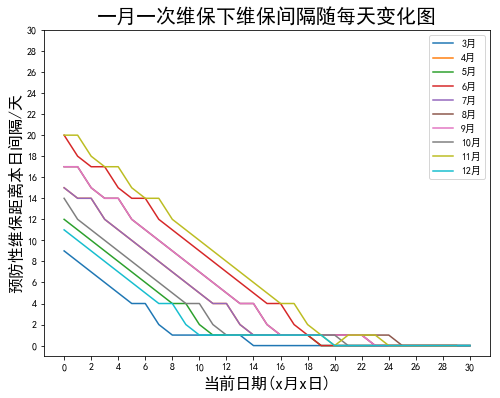

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']
fig,ax=plt.subplots(1,1,figsize=(8,6))
mon_cnt=3
for mon in mons_best_int[2:]:
    ax.plot(mon,label='{:}月'.format(mon_cnt))
    mon_cnt+=1
plt.legend()
plt.xticks(np.arange(0,32,2))
plt.yticks(np.arange(0,32,2))
plt.xlabel('当前日期(x月x日)',fontsize=16)
plt.ylabel('预防性维保距离本日间隔/天',fontsize=16)
plt.title('一月一次维保下维保间隔随每天变化图',fontsize=20)
plt.savefig('最优维保间隔优化结果图.png')
plt.show()

In [58]:
mons_best_int

array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([9, 8, 7, 6, 5, 4, 4, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([15, 14, 14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
       list([12, 11, 10, 9, 8, 7, 6, 5, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([20, 18, 17, 17, 15, 14, 14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([15, 14, 14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([17, 17, 15, 14, 14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
       list([17, 17, 15, 14, 14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
     

No handles with labels found to put in legend.


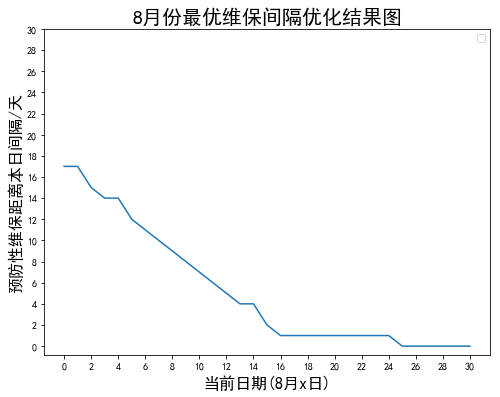

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']
fig,ax=plt.subplots(1,1,figsize=(8,6))
#mon_cnt=4
#for mon in mons_best_int[3:8]:
#    ax.plot(mon,label='{:}月'.format(mon_cnt))
#    mon_cnt+=1
ax.plot(mons_best_int[7])
plt.legend()
plt.xticks(np.arange(0,32,2))
plt.yticks(np.arange(0,32,2))
plt.xlabel('当前日期(8月x日)',fontsize=16)
plt.ylabel('预防性维保距离本日间隔/天',fontsize=16)
plt.title('8月份最优维保间隔优化结果图',fontsize=20)
plt.savefig('8月份最优维保间隔优化结果图.png')
plt.show()

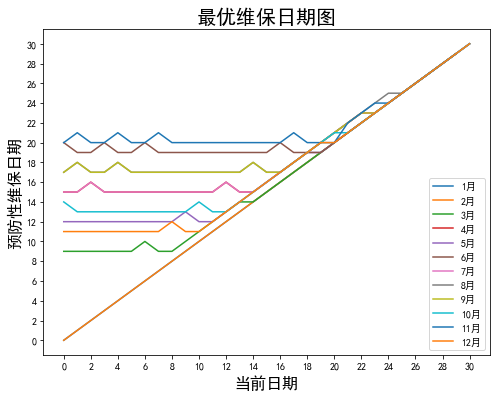

In [35]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
mon_cnt=1
for mon in mons_best_int:
    x=list(range(len(mon)))
    mon_x=[]
    for i in range(len(x)):
        mon_x.append(mon[i]+x[i])
    ax.plot(mon_x,label='{:}月'.format(mon_cnt))
    mon_cnt+=1
ax.legend()
plt.xticks(np.arange(0,32,2))
plt.yticks(np.arange(0,32,2))
plt.xlabel('当前日期',fontsize=16)
plt.ylabel('预防性维保日期',fontsize=16)
plt.title('最优维保日期图',fontsize=20)
plt.savefig('最优维保日期图.png')

In [17]:
model=Model(year=2014,month=8,day=1,label=0)
model.findBestMaintInterval()

->model.now: 2014-08-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in greater
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in greater


->Maintenance interval: (array([20], dtype=int64),)  days with money 167.76330235409412


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in greater


20

->model.now: 2014-02-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in greater
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in greater


->Maintenance interval: (array([17], dtype=int64),)  days with money 23.529411768915256


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in greater


->model.now: 2014-03-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([20], dtype=int64),)  days with money 88.08227926084552
->model.now: 2014-04-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([25], dtype=int64),)  days with money 185.25215612985014
->model.now: 2014-05-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([12], dtype=int64),)  days with money 154.37394965791464
->model.now: 2014-06-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([23], dtype=int64),)  days with money 254.44670136951126
->model.now: 2014-07-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([20], dtype=int64),)  days with money 178.24480001217339
->model.now: 2014-08-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([20], dtype=int64),)  days with money 167.76330235409412
->model.now: 2014-09-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([23], dtype=int64),)  days with money 208.0032040126077
->model.now: 2014-10-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([12], dtype=int64),)  days with money 211.2534705852962
->model.now: 2014-11-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([14], dtype=int64),)  days with money 149.56823468076183
->model.now: 2014-12-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


->Maintenance interval: (array([26], dtype=int64),)  days with money 233.07152436022432
[0.09803921570381356, 0.27525712269014224, 0.6810741034185667, 0.5242467943585251, 0.852667137568043, 0.6481629091351759, 0.5864606967886765, 0.7635038242526276, 0.7828530159963963, 0.5562800674648021, 0.8714399915238474]


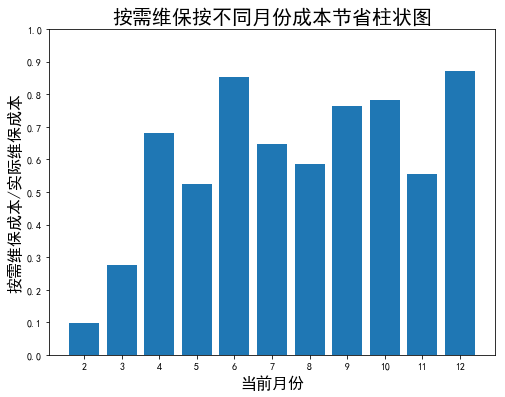

In [50]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']
fig,ax=plt.subplots(1,1,figsize=(8,6))
cost_ratio=[]
for i in range(2,13):
    m=Model(year=2014,month=i,day=1,label=0)
    t=m.findBestMaintInterval()
    c=m.Ct_lambda(t)/(len(m.index)*160/len(m.index_unique)+40*2)
    cost_ratio.append(c)
print(cost_ratio)
ax.bar(list(range(2,13)),cost_ratio)
plt.xticks(np.arange(2,13,1))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('当前月份',fontsize=16)
plt.ylabel('按需维保成本/实际维保成本',fontsize=16)
plt.title('按需维保按不同月份成本节省柱状图',fontsize=20)
plt.savefig('按需维保按不同月份成本节省柱状图.png')

In [ ]:
fig, ax = plt.subplots()
x_ticks=[]
for lab in range(0,6):
    model=Model(year=2014,month=8,day=1,label=lab)
    ax.bar(lab,2+model.findBestMaintInterval())
    x_ticks.append(len(model.samples))
ax.set_xticks(range(0,6))
ax.set_xticklabels(x_ticks)

In [46]:
m=Model(year=2014,month=1,day=1,label=0)

->model.now: 2014-01-01 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [48]:
m.findBestMaintInterval()
m.Ct_lambda(0)

C:\Software\Programming\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Software\Programming\Anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

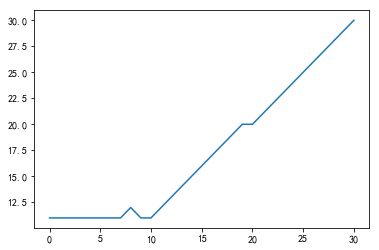

In [30]:
%matplotlib inline
plt.plot(mon_x)

In [40]:
m=Model(year=2014,month=5,day=2)

->model.now: 2014-05-02 00:00:00


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [44]:
m.findBestMaintInterval()
a=m.Ct_lambda
x=np.arange(0.1,30,0.1)

->Maintenance interval: (array([11], dtype=int64),)  days with money 471.864856805092


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in greater
C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater


C:\Software\Programming\Anaconda\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in power
  """


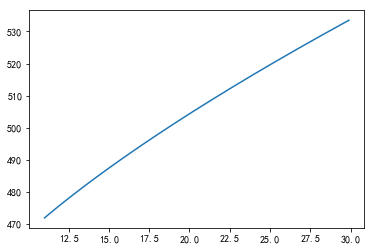

In [45]:
plt.plot(x,a(x))